<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/decision_under_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single stage decisions

## Demand side management through ripple control
In our first example, as introduced in [EX 7](https://www.notion.so/E7-Decision-under-uncertainty-61b0002c6f764d2eb4721a616124f8d9#c19ee850da4c4f9796003ff0870a3ffd), we want to predict the activation time of an heat pump, knowing historical values of the power measurements of its household. 

We can tackle the problem in three steps:
* estimate the nominal power of the HP  $\hat{P}_{hp}$. Usually, devices are not directly measuered, and metadata are rarely available. This means that we have to estimate the nominal power of the HP directly from the meter measurements.
* estimate the energy signature of the household as a funciton of the predicted average external temperature $\hat{E}_{d}(\hat{T}_d)$
* estimate the forecasting error for the estimation of the average daily tempearture $\hat{T}_d$

Finally, we can combine these estimations to retrieve the expected time needede by the HP to heat the household as, in terms of equivalent hours:

$$\hat{h}_{eq} = \frac{\hat{E}_{d}(\hat{T}_d)}{\hat{P}_{hp}}$$

Needless to say, both $\hat{P}_{hp}$ and $\hat{E}_{d}(\hat{T}_d)$ are probabilistc estimations with associated variance, which we'll have to properly consider when estimating $\hat{h}_{eq}$.

We start by loading the household dataset:

In [1]:
!git clone https://github.com/nepslor/teaching.git
!pip install pandas==1.5.1


Cloning into 'teaching'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 333 (delta 69), reused 107 (delta 54), pack-reused 201
Receiving objects: 100% (333/333), 82.87 MiB | 22.25 MiB/s, done.
Resolving deltas: 100% (143/143), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 22.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from teaching.TimeSeriesForecasting.utils.merge_ramps import merge_ramps

data = pd.read_pickle('teaching/TimeSeriesForecasting/data/energy_signature_data.zip')
data.head()


,GHI,T,heat_pump_p,heat_pump_q,main_p,main_q,relay,nwp_temperature
2015-10-01 00:00:00+00:00,-2.781167,9.500000,0.0,0.0,0.407500,0.520833,NaN,NaN
2015-10-01 00:01:00+00:00,-2.803333,9.496667,0.0,0.0,0.435333,0.520500,NaN,NaN
2015-10-01 00:02:00+00:00,-2.856000,9.400000,0.0,0.0,0.423833,0.521500,NaN,NaN
2015-10-01 00:03:00+00:00,-2.886833,9.400000,0.0,0.0,0.402000,0.517667,NaN,NaN
2015-10-01 00:04:00+00:00,-2.911667,9.400000,0.0,0.0,0.400833,0.516833,NaN,NaN


### Nominal power estimation
Before detecting the HP nominal power, derivatives and observations must be at first merged, since sampling introduce dispersion in the distribution of the power jumps, making it difficult to spot accumulation points.


<center>
<img src="https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/figs/merging_derivatives.png" width="400", centered=True>
</center>

<font size="-2"><p><center>Example of sampling-induced dispersion. Blue: before merging derivatives. Orange: after merging, clusters are clearly visible</center></p></font>

This is the task of the function `merge_ramps` that we've loaded from the course repo. 


In [3]:
data_diffs = data.copy()
for k in ['main_p', 'main_q', 'heat_pump_p', 'heat_pump_q']:
  data_diffs[k].iloc[:-1], _, _ = merge_ramps(data[k])

We can now have a look at the power distribution of:
* the smart meter 
* the HP (that we will use only as a reference)
* the HP, filtered by positive jumps of the relay status (that is, when the HP is being switched off)
 

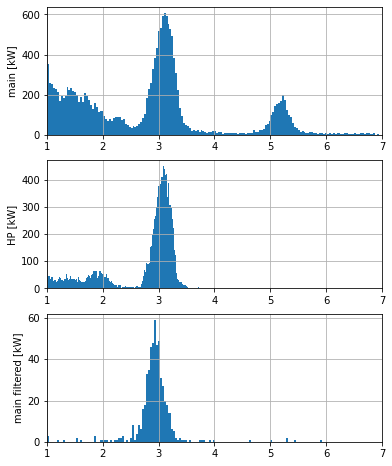

In [4]:
n_bins = 200

filt = data_diffs['main_p']>1
relay_on_filt = np.roll(data[['relay']].diff().values==1, 1)

fig, ax= plt.subplots(3, 1, figsize=(6, 8))

data_diffs['main_p'].loc[filt].\
    hist(bins=n_bins*2, ax=ax[0])

data_diffs['heat_pump_p'].loc[data_diffs['heat_pump_p']>1].\
    hist(bins=n_bins, ax=ax[1])

main_jumps = data_diffs['main_p'].loc[relay_on_filt]
hp_jumps = main_jumps.loc[main_jumps>1]
hp_jumps.hist(bins=n_bins, ax=ax[2])
[a.set_ylabel(t) for a, t in zip(ax, ['main [kW]', 'HP [kW]', 'main filtered [kW]'])]
[a.set_xlim([1, 7]) for a in ax.ravel()];


### 🥋 EX 1: find sampling PDF for the HP's power
Starting from `hp_jumps`, find a reasonable PDF for the HP's power by filtering out outliers. Call the resulting filtered observations `p_pdf`

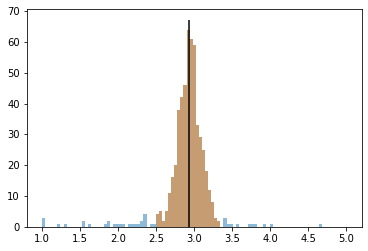

In [5]:
def filter_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df.loc[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))]


# find the PDF for the nominal power to sample from
p_pdf = filter_outliers(hp_jumps)
p_exp = np.mean(p_pdf)

fig, ax = plt.subplots(1, 1)
ax.hist(hp_jumps, bins=np.linspace(1, 5, 100), alpha=0.5)
ax.hist(p_pdf, bins=np.linspace(1, 5, 100), alpha=0.5)
ax.vlines(p_exp, *plt.ylim())
plt.show()

### Energy signature
In the following we'll fit a picewise linear function on the average values of measured external temperature and power at the household's main. We need to fit a piecewise function since we assume that after a given temperature the HP wont' be activated (in this household the HP is just used for space heating and not for cooling).



[ 1.27127179e+01 -1.40187479e-01  1.03404319e+00 -3.88081207e+00
  2.50000000e+01  4.29026903e-03]


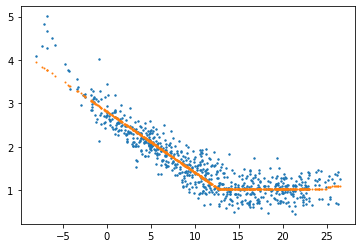

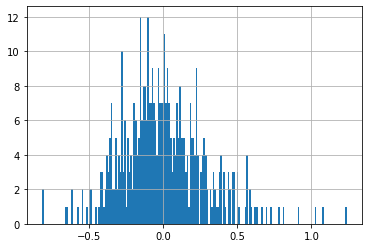

In [6]:

# fit an energy signature
from scipy import optimize

def es_fun(k, T):
    return np.piecewise(T, [T < k[0],T > k[4]], [lambda T:k[1]*T + k[2]-k[1]*k[0], lambda T:k[5]*T + k[2]-k[5]*k[0], lambda T: k[2]])
x0 = np.array([15, -1, 5, 0, 25, 1])

T = data['T'].resample('1d').mean()
p = data['main_p'].resample('1d').mean()
min_bounds = np.array([10, -100, 0, -10, 20,0]) 
max_bounds = np.array([20, 0, np.inf, 10, 30, np.inf]) 
res_robust = optimize.least_squares(lambda k, T, y: es_fun(k, T)-p, x0, args=(T.values, p.values), loss='huber', bounds=(min_bounds, max_bounds))
print(res_robust.x)

# find errors when the HP is active
plt.scatter(T, p, s=2)
plt.scatter(T, es_fun(res_robust.x, T.values), s=1)
plt.show()

residuals = p-(es_fun(res_robust.x, T.values))
residuals_hp_on = residuals.loc[T<res_robust.x[0]]
residuals_hp_on.hist(bins=n_bins)
plt.show()

es_pdf = residuals_hp_on
es_pdf.name = 'es'

### 🥋 EX2: find the PDF for the NWP's mean external temperature
Starting from the `nwp_temperature` column, retrieve the PDF of the prediction errors for the external temperature provided by the NWP provider. Call it `T_pdf`

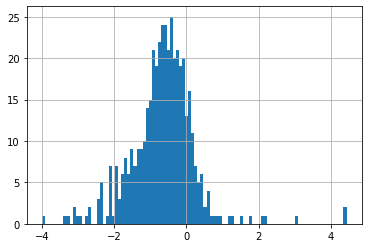

In [7]:
d_data = data.resample('1d').mean()
filt = ~d_data['nwp_temperature'].isna()
T_pdf = d_data.loc[filt]['T'] -d_data.loc[filt]['nwp_temperature']
T_pdf.name = 'T_nwp'
T_pdf.hist(bins=100)
plt.show()

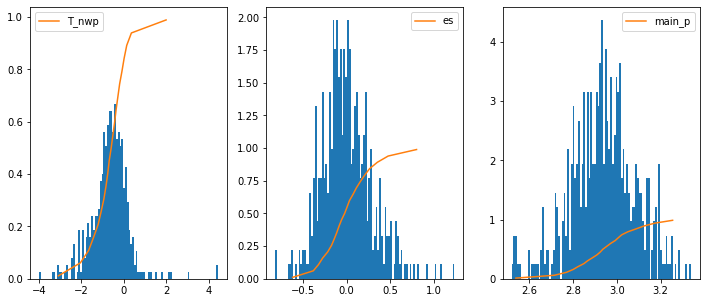

In [8]:
def get_cdf(df, q_levels):
  n = len(df)
  quantiles = np.quantile(df, q_levels)
  cdf = [np.sum(df<q)/n for q in quantiles]
  return pd.DataFrame(cdf, index=quantiles, columns=[df.name])

q_levels = np.linspace(0.01, 0.99, 21)
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
T_pdf.hist(ax=ax[0], density=True, bins=100)
get_cdf(T_pdf, q_levels).plot(ax=ax[0])
es_pdf.hist(ax=ax[1], density=True, bins=100)
get_cdf(es_pdf, q_levels).plot(ax=ax[1])
p_pdf.hist(ax=ax[2], density=True, bins=100)
get_cdf(p_pdf, q_levels).plot(ax=ax[2])


## Dealing with uncertainty in the estimated PDF


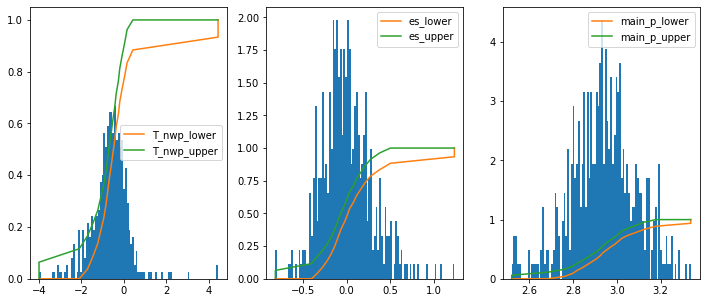

In [9]:
from scipy.stats import ksone

def ks_critical_value(n_trials, alpha):
    return ksone.ppf(1-alpha/2, n_trials)

def get_cdf_boundaries(df, q_levels, alpha_level=0.05):
  n = len(df)
  ks_val = ks_critical_value(n, alpha_level)
  quantiles = np.quantile(df, q_levels)
  cdf = [np.sum(df<q)/n for q in quantiles]
  lower_bound = np.minimum(1, np.maximum(0, cdf -ks_val))
  upper_bound = np.minimum(1, np.maximum(0, cdf +ks_val))
  lower_bound = np.hstack([0, lower_bound, 1])
  upper_bound = np.hstack([0, upper_bound, 1])
  cdf_lims = np.vstack([lower_bound, upper_bound]).T
  return pd.DataFrame(cdf_lims, index=np.hstack([quantiles[0]-1e-6, quantiles,quantiles[-1]+1e-6]), columns=['{}_lower'.format(df.name), '{}_upper'.format(df.name)])

q_levels = np.linspace(0, 1, 21)
T_cdf_bounds = get_cdf_boundaries(T_pdf, q_levels)
es_cdf_bounds = get_cdf_boundaries(es_pdf, q_levels)
p_cdf_bounds = get_cdf_boundaries(p_pdf, q_levels)
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

T_pdf.hist(ax=ax[0], density=True, bins=100)
T_cdf_bounds.plot(ax=ax[0])

es_pdf.hist(ax=ax[1], density=True, bins=100)
es_cdf_bounds.plot(ax=ax[1])

p_pdf.hist(ax=ax[2], density=True, bins=100)
p_cdf_bounds.plot(ax=ax[2])


In [20]:
from scipy.interpolate import interp1d

class CDFBoundarySampler:
  def __init__(self, df):
    self.f_lower = interp1d(df.iloc[:, 0], df.index)
    self.f_upper = interp1d(df.iloc[:, 1], df.index)
    
  def sample(self, n_samples, n_inner_samples=1):
    seeds = np.random.rand(n_samples)
    samples = []
    for i, seed in enumerate(seeds):
      lower_bound = self.f_lower(seed)
      upper_bound = self.f_upper(seed)    
      samples.append((np.random.rand(n_inner_samples)) * (upper_bound-lower_bound) + lower_bound)
    return np.hstack(samples)

T_sampler = CDFBoundarySampler(T_cdf_bounds)
es_sampler = CDFBoundarySampler(es_cdf_bounds)
p_sampler = CDFBoundarySampler(p_cdf_bounds)


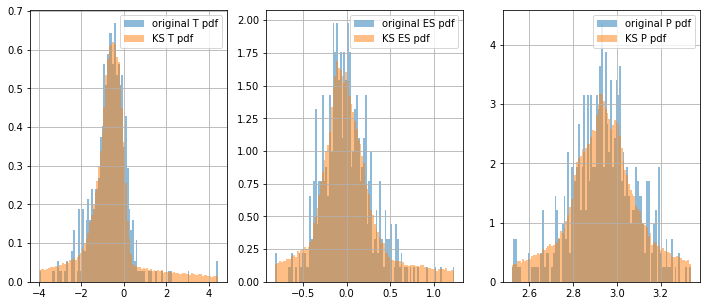

In [54]:
n_samples = 100000
T_samples = T_sampler.sample(n_samples)
es_samples = es_sampler.sample(n_samples)
p_samples = p_sampler.sample(n_samples)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
T_pdf.hist(ax=ax[0], density=True, bins=100, alpha=0.5, label='original T pdf')
ax[0].hist(T_samples, density=True, bins=100, alpha=0.5, label='KS T pdf')

es_pdf.hist(ax=ax[1], density=True, bins=100, alpha=0.5, label='original ES pdf')
ax[1].hist(es_samples, density=True, bins=100, alpha=0.5, label='KS ES pdf')

p_pdf.hist(ax=ax[2], density=True, bins=100, alpha=0.5, label='original P pdf')
ax[2].hist(p_samples, density=True, bins=100, alpha=0.5, label='KS P pdf')
[a.legend() for a in ax.ravel()];

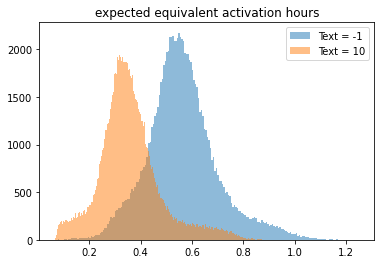

In [55]:
from functools import partial 

def activation_time(t_error, es_error, p_hp, es_function, t_ref=10):
  temperature = t_ref + t_error
  energy_needed = es_function(temperature) + es_error 
  hours = energy_needed / p_hp
  return hours

T_low = -1
T_high = 10
a_10 = activation_time(T_low + T_samples, es_samples, p_samples, partial(es_fun, res_robust.x))

plt.hist(a_10, bins=200, label='Text = {}'.format(T_low), alpha=0.5);
plt.hist(activation_time(T_high + T_samples, es_samples, p_samples, partial(es_fun, res_robust.x)), bins=200, label='Text = {}'.format(T_high), alpha=0.5);
plt.legend()
plt.title('expected equivalent activation hours');

In [71]:
class GeneralizedUncertaintyPropagation:
  def __init__(self, boundary_samplers, model):
    self.boundary_samplers = boundary_samplers
    self.model = model

  def sample(self, n_outer, n_samples=1, n_inner_samples=100):
    seeds = np.random.rand(n_outer)
    pdf_out_min, pdf_out_max = np.zeros(n_outer), np.zeros(n_outer)
    for i, seed in enumerate(seeds):
      inner_samples = {}
      for name, bs in self.boundary_samplers.items():
        inner_samples[name] = bs.sample(n_samples, n_inner_samples=n_inner_samples)
      inner_res = self.model(**inner_samples)
      pdf_out_max[i] = np.max(inner_res)
      pdf_out_min[i] = np.min(inner_res)
    return pdf_out_min, pdf_out_max

gup = GeneralizedUncertaintyPropagation({'t_error':T_sampler, 'es_error': es_sampler, 'p_hp': p_sampler}, partial(activation_time, es_function=partial(es_fun, res_robust.x), t_ref=10))
pdf_min, pdf_max = gup.sample(10000, n_inner_samples=100)

pdf2_min, pdf2_max = gup.sample(10000, n_samples=100, n_inner_samples=100)

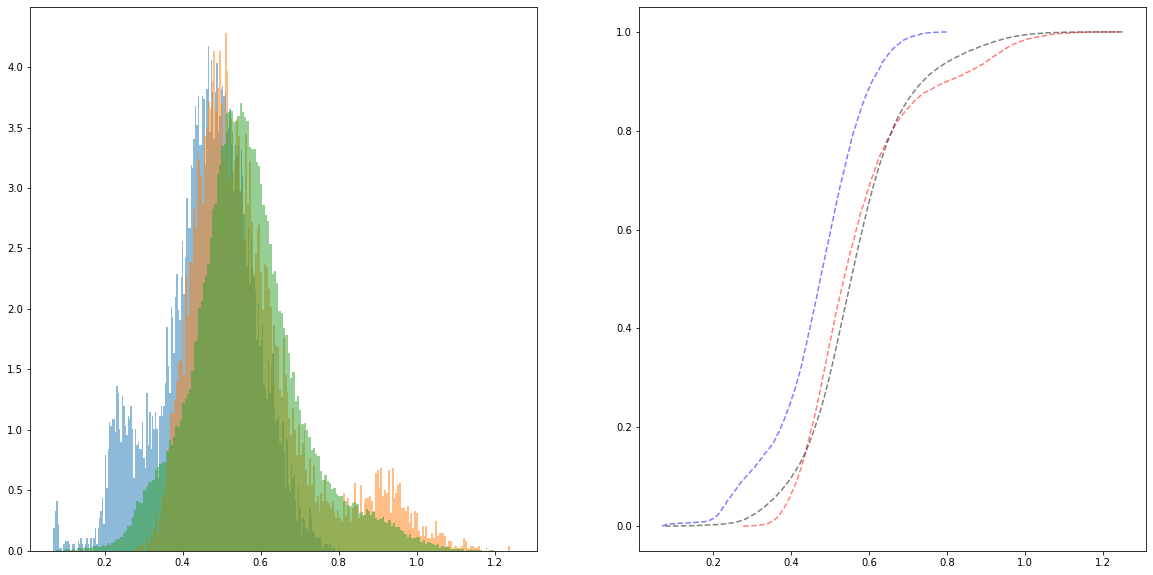

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(pdf_min, bins=n_bins, alpha=0.5, density=True);
ax[0].hist(pdf_max, bins=n_bins, alpha=0.5, density=True);
ax[0].hist(a_10, bins=n_bins, label='Text = {}'.format(T_low), alpha=0.5, density=True);


ax[1].plot(np.sort(pdf_min), np.linspace(0, 1, len(pdf_min), endpoint=False), '--b', alpha=0.5, label='Upper CDF (T=10)')
ax[1].plot(np.sort(pdf_max), np.linspace(0, 1, len(pdf_max), endpoint=False), '--r', alpha=0.5, label='Upper CDF (T=10)')
ax[1].plot(np.sort(a_10), np.linspace(0, 1, len(a_10), endpoint=False), '--k', alpha=0.5, label='Upper CDF (T=10)')


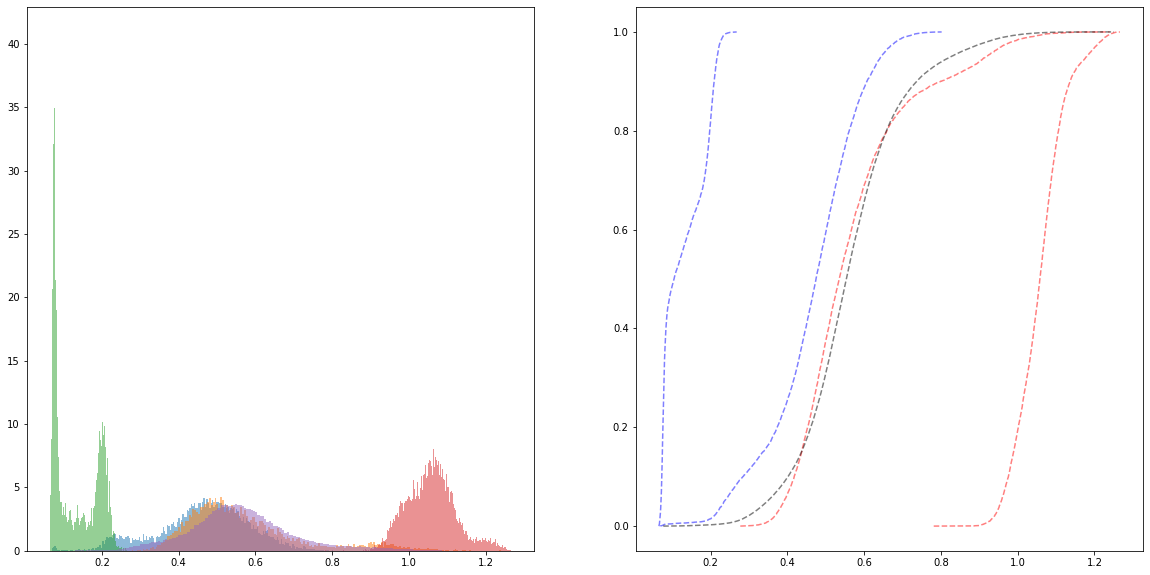

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(pdf_min, bins=n_bins, alpha=0.5, density=True);
ax[0].hist(pdf_max, bins=n_bins, alpha=0.5, density=True);
ax[0].hist(pdf2_min, bins=n_bins, alpha=0.5, density=True);
ax[0].hist(pdf2_max, bins=n_bins, alpha=0.5, density=True);
ax[0].hist(a_10, bins=n_bins, label='Text = {}'.format(T_low), alpha=0.5, density=True);


ax[1].plot(np.sort(pdf_min), np.linspace(0, 1, len(pdf_min), endpoint=False), '--b', alpha=0.5, label='Upper CDF (T=10)')
ax[1].plot(np.sort(pdf_max), np.linspace(0, 1, len(pdf_max), endpoint=False), '--r', alpha=0.5, label='Upper CDF (T=10)')
ax[1].plot(np.sort(pdf2_min), np.linspace(0, 1, len(pdf2_min), endpoint=False), '--b', alpha=0.5, label='Upper CDF (T=10)')
ax[1].plot(np.sort(pdf2_max), np.linspace(0, 1, len(pdf2_max), endpoint=False), '--r', alpha=0.5, label='Upper CDF (T=10)')
ax[1].plot(np.sort(a_10), np.linspace(0, 1, len(a_10), endpoint=False), '--k', alpha=0.5, label='Upper CDF (T=10)')
